In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os
import shutil

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs
from schmeud._schmeud import statics
from schmeud import ml
from tqdm import tqdm

from dataclasses import dataclass
from collections import defaultdict

from numba import njit

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12], '_status': {}}

In [4]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [51]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "ESL":
    #     continue
    # print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        new_df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/ave-softness-fft-abs_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3: # or float(max_shear) != 0.12
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue
        
        traj = gsd.hoomd.open(exper)
        
        softs = np.stack(dataset["soft"].to_numpy())[:-1]
        nsofts = softs.reshape(5, 40, 32768)
        nsofts = nsofts.mean(axis=0)

        # compute fft
        soft_ffts = np.fft.fft(nsofts.T, axis=-1)

        mean_ffts = np.mean(soft_ffts, axis=0)

        output[sp].append(mean_ffts)
        

634e14bc75836df75158fb15f379d8bb


7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5
9158e73b2e4c9fd1a565e1e5d1bc3af5
c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18


In [86]:
sum_ffts = np.abs(np.sum(soft_ffts, axis=0))

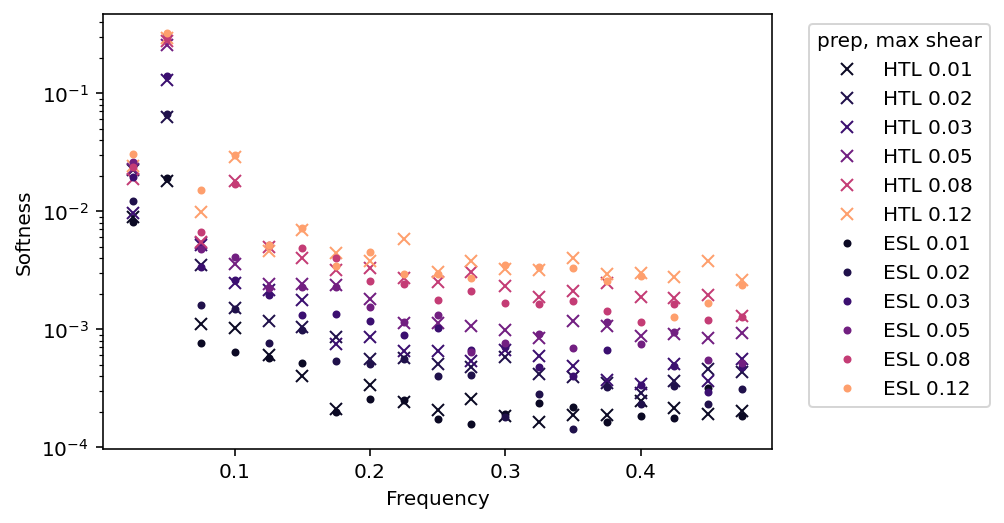

In [6]:
cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=0.15)

xs = np.fft.fftfreq(40)

for key, value in output.items():
    if key.prep == "HTL":
        ln = "x"
    else:
        ln = "."
    # print(key, len(value))
    # dataset = pl.concat(value)
    plt.plot(xs[1:20], np.mean(value, axis=0)[1:20], ln, color=cmap(norm(key.max_shear)), label=f"{key.prep} {key.max_shear:.2f}")
    # break
plt.xlabel("Frequency")
plt.ylabel("Softness")
# put legend outside to the right
plt.legend(title="prep, max shear", bbox_to_anchor=(1.04,1), loc="upper left")
plt.yscale('log')

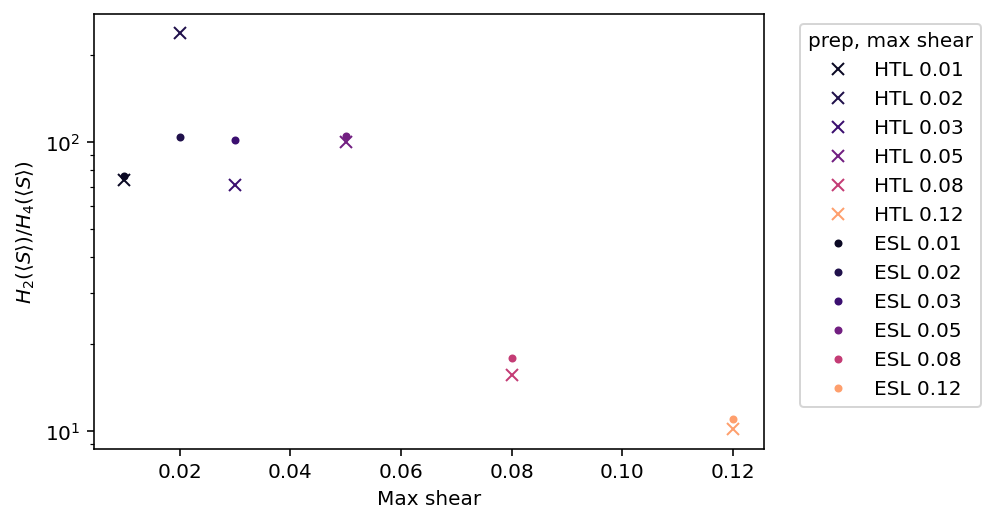

In [52]:
cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=0.15)

xs = np.fft.fftfreq(40)

i = 2
j = 4

for key, value in output.items():
    if key.prep == "HTL":
        ln = "x"
    else:
        ln = "."
    # print(key, len(value))
    # dataset = pl.concat(value)
    data = np.mean(value, axis=0)
    plt.plot(key.max_shear, np.abs(data[i]/data[j]), ln, color=cmap(norm(key.max_shear)), label=f"{key.prep} {key.max_shear:.2f}")
    # break
plt.xlabel("Max shear")
plt.ylabel(rf"$H_{i}(\langle S \rangle)/H_{j}(\langle S \rangle)$")
# put legend outside to the right
plt.legend(title="prep, max shear", bbox_to_anchor=(1.04,1), loc="upper left")
plt.yscale('log')

In [53]:
data[i]

(-0.257467640654656-0.18688649403193594j)

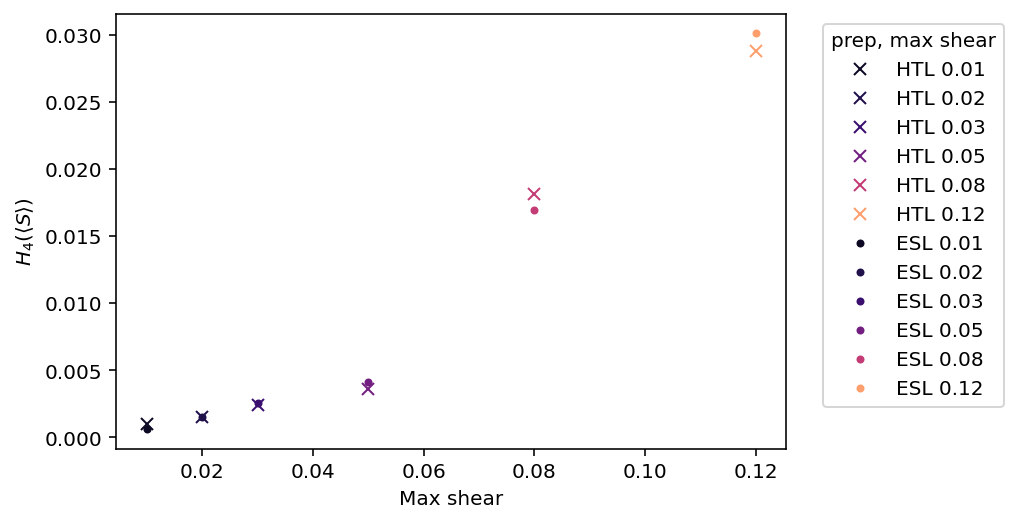

In [23]:
cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=0.15)

xs = np.fft.fftfreq(40)
i = 4

for key, value in output.items():
    if key.prep == "HTL":
        ln = "x"
    else:
        ln = "."
    # print(key, len(value))
    # dataset = pl.concat(value)
    plt.plot(key.max_shear, np.mean(value, axis=0)[i], ln, color=cmap(norm(key.max_shear)), label=f"{key.prep} {key.max_shear:.2f}")
    # break
plt.xlabel("Max shear")
plt.ylabel(rf"$H_{i}(\langle S \rangle)$")
# put legend outside to the right
plt.legend(title="prep, max shear", bbox_to_anchor=(1.04,1), loc="upper left")

In [31]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "ESL":
    #     continue
    # print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        new_df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/ave-softness-fft-abs_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3: # or float(max_shear) != 0.12
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue
        
        traj = gsd.hoomd.open(exper)
        
        softs = np.stack(dataset["soft"].to_numpy())[:-1]
        nsofts = softs.reshape(5, 40, 32768)
        nsofts = nsofts.mean(axis=0)

        # compute fft
        soft_ffts = np.fft.fft(nsofts.T, axis=-1)

        output[sp].append(soft_ffts)
        

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5
9158e73b2e4c9fd1a565e1e5d1bc3af5
c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18


In [ ]:
cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=0.15)

xs = np.fft.fftfreq(40)

for key, value in output.items():
    if key.prep == "HTL":
        ln = "x"
    else:
        ln = "."
    # print(key, len(value))
    # dataset = pl.concat(value)
    for i in range(4,5):
        plt.plot(key.max_shear, np.mean(value, axis=0)[i], ln, color=cmap(norm(key.max_shear)), label=f"{key.prep} {key.max_shear:.2f}")
    # break
plt.xlabel("Cycle")
plt.ylabel("Softness")
# put legend outside to the right
plt.legend(title="prep, max shear", bbox_to_anchor=(1.04,1), loc="upper left")

In [180]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        new_df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/ave-softness-fft-abs_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.12:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue
        
        traj = gsd.hoomd.open(exper)
        
        softs = np.stack(dataset["soft"].to_numpy())[:-1]
        nsofts = softs.reshape(5, 40, 32768)
        nsofts = nsofts.mean(axis=0)

        # compute fft
        soft_ffts = np.fft.fft(nsofts.T, axis=-1)

        snap = traj[dataset["frame"][0]]

        # output[sp].append(soft_ffts)
        break
    break

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
ESL


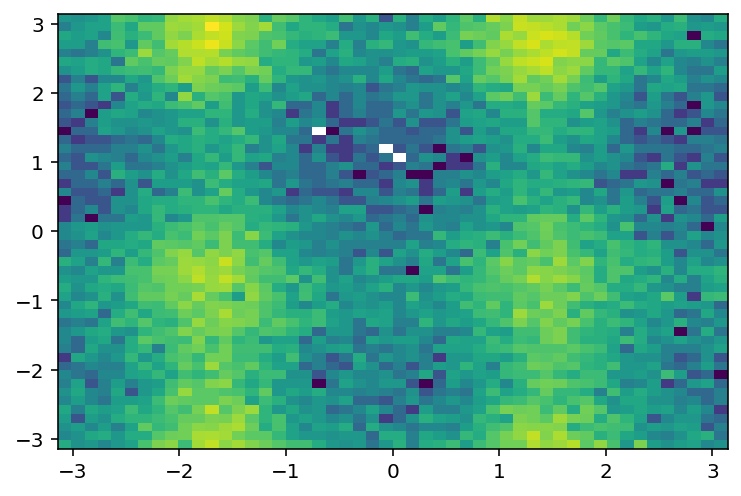

In [183]:
plt.hist2d(np.angle(soft_ffts[:, 1]), np.angle(soft_ffts[:, 2]), bins=50, norm=mpl.colors.LogNorm());

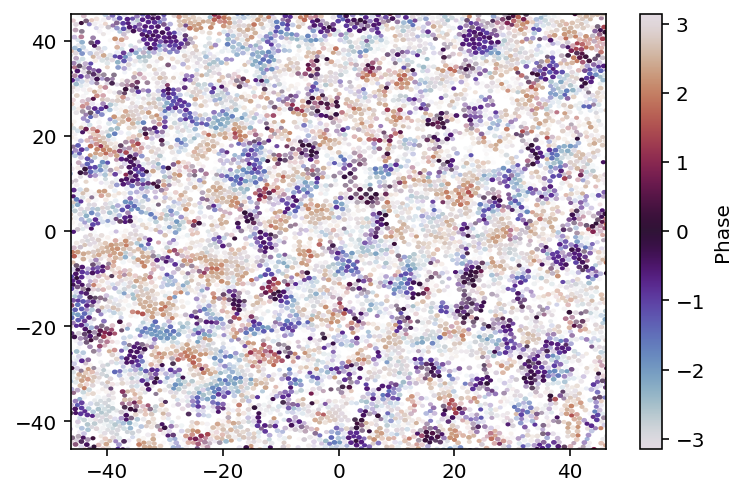

In [187]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

# extract particle positions and data
positions = snap.particles.position
diams = snap.particles.diameter
i = 2
color_data = np.angle(soft_ffts[:,i])
abs_data = np.abs(soft_ffts[:,i])

# create a list of circles with positions and radius
circles = [Circle((x[0], x[1]), radius=d/2.0) for x, d in zip(positions, diams)]

# create a patch collection with circles and color data
# norm = colors.LogNorm(vmax=100)
norm = colors.Normalize()
collection = PatchCollection(circles, cmap='twilight', norm=norm)
collection.set_array(color_data)
norm2 = colors.Normalize(vmin=np.quantile(abs_data, 0.2), vmax=np.quantile(abs_data, 0.8))
alpha = norm2(abs_data)
# clamp between 0 and 1
alpha = np.clip(alpha, 0, 1)
collection.set_alpha(alpha)

# plot particles with color
fig, ax = plt.subplots()
ax.add_collection(collection)
ax.autoscale()

# zoom in 5x
zoom = 2
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim((xlim[0] + xlim[1])/2 - (xlim[1] - xlim[0])/zoom/2, (xlim[0] + xlim[1])/2 + (xlim[1] - xlim[0])/zoom/2)
ax.set_ylim((ylim[0] + ylim[1])/2 - (ylim[1] - ylim[0])/zoom/2, (ylim[0] + ylim[1])/2 + (ylim[1] - ylim[0])/zoom/2)

plt.colorbar(collection, label="Phase")

plt.show()


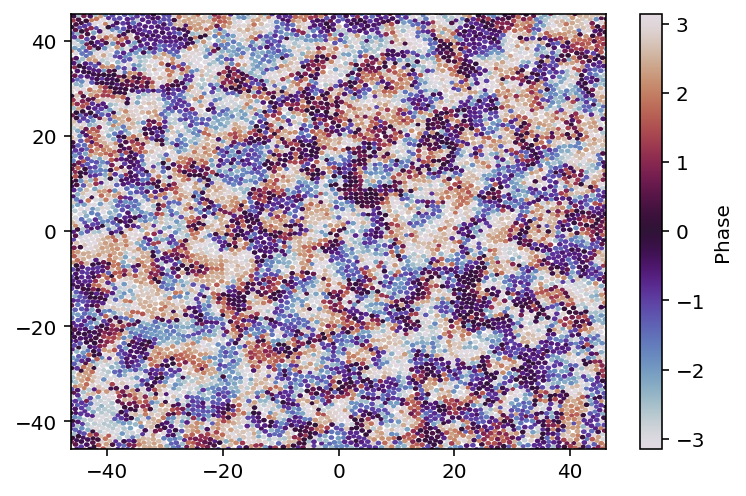

In [188]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

# extract particle positions and data
positions = snap.particles.position
diams = snap.particles.diameter
i = 2
color_data = np.angle(soft_ffts[:,i])
abs_data = np.abs(soft_ffts[:,i])

# create a list of circles with positions and radius
circles = [Circle((x[0], x[1]), radius=d/2.0) for x, d in zip(positions, diams)]

# create a patch collection with circles and color data
# norm = colors.LogNorm(vmax=100)
norm = colors.Normalize()
collection = PatchCollection(circles, cmap='twilight', norm=norm)
collection.set_array(color_data)
# norm2 = colors.Normalize(vmin=np.quantile(abs_data, 0.2), vmax=np.quantile(abs_data, 0.8))
# alpha = norm2(abs_data)
# # clamp between 0 and 1
# alpha = np.clip(alpha, 0, 1)
# collection.set_alpha(alpha)

# plot particles with color
fig, ax = plt.subplots()
ax.add_collection(collection)
ax.autoscale()

# zoom in 5x
zoom = 2
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim((xlim[0] + xlim[1])/2 - (xlim[1] - xlim[0])/zoom/2, (xlim[0] + xlim[1])/2 + (xlim[1] - xlim[0])/zoom/2)
ax.set_ylim((ylim[0] + ylim[1])/2 - (ylim[1] - ylim[0])/zoom/2, (ylim[0] + ylim[1])/2 + (ylim[1] - ylim[0])/zoom/2)

plt.colorbar(collection, label="Phase")

plt.show()


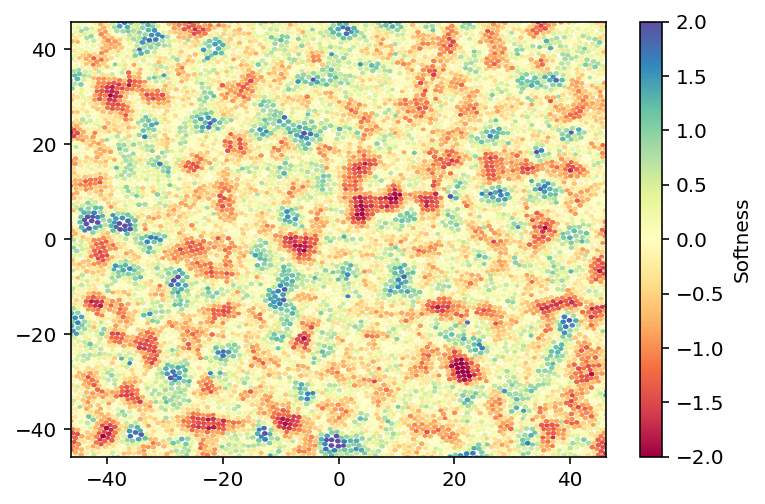

In [186]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

# extract particle positions and data
positions = snap.particles.position
diams = snap.particles.diameter
i = 2
color_data = softs[0]

# create a list of circles with positions and radius
circles = [Circle((x[0], x[1]), radius=d/2.0) for x, d in zip(positions, diams)]

# create a patch collection with circles and color data
# norm = colors.LogNorm(vmax=100)
norm = colors.Normalize(-2, 2)
import seaborn as sns
cmap = sns.color_palette("Spectral", as_cmap=True)
collection = PatchCollection(circles, cmap=cmap, norm=norm)
collection.set_array(color_data)
# norm2 = colors.Normalize(vmin=np.quantile(abs_data, 0.2), vmax=np.quantile(abs_data, 0.8))
# alpha = norm2(abs_data)
# # clamp between 0 and 1
# alpha = np.clip(alpha, 0, 1)
# collection.set_alpha(alpha)

# plot particles with color
fig, ax = plt.subplots()
ax.add_collection(collection)
ax.autoscale()

# zoom in 5x
zoom = 2
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim((xlim[0] + xlim[1])/2 - (xlim[1] - xlim[0])/zoom/2, (xlim[0] + xlim[1])/2 + (xlim[1] - xlim[0])/zoom/2)
ax.set_ylim((ylim[0] + ylim[1])/2 - (ylim[1] - ylim[0])/zoom/2, (ylim[0] + ylim[1])/2 + (ylim[1] - ylim[0])/zoom/2)

plt.colorbar(collection, label="Softness")

plt.show()


In [54]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        new_df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/ave-softness-fft-abs_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.05:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue
        
        traj = gsd.hoomd.open(exper)
        
        softs = np.stack(dataset["soft"].to_numpy())[:-1]
        nsofts = softs.reshape(5, 40, 32768)
        nsofts = nsofts.mean(axis=0)

        # compute fft
        soft_ffts = np.fft.fft(nsofts.T, axis=-1)

        snap = traj[dataset["frame"][0]]

        # output[sp].append(soft_ffts)
        break
    break

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
ESL


Text(0.5, 0, '$\\angle H_2(\\langle S \\rangle)$')

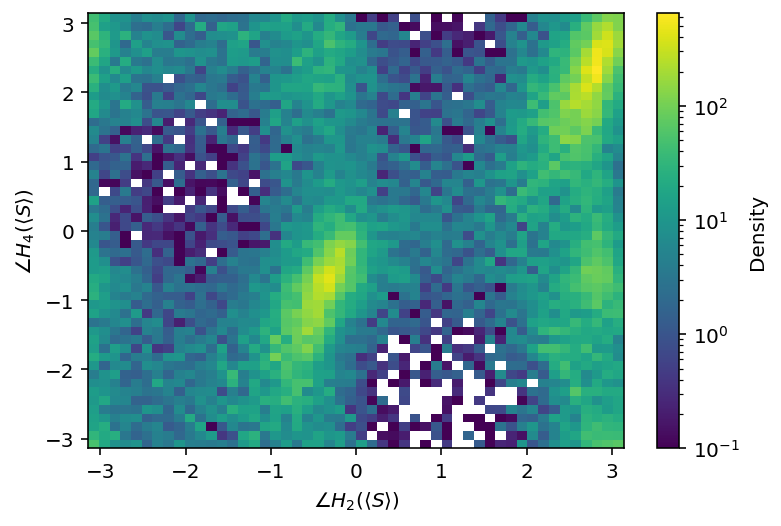

In [55]:
i = 2
j = 4
a = soft_ffts[:,i]
b = soft_ffts[:,j]
angle_a = np.angle(a)
angle_b = np.angle(b)
abs_a = np.abs(a)
abs_b = np.abs(b)
weight = abs_a*abs_b
# weight=np.ones_like(angle_a, dtype=np.float32)
plt.hist2d(angle_a, angle_b, weights=weight, bins=50, norm=colors.LogNorm(0.1));
plt.colorbar(label="Density");
plt.ylabel(rf"$\angle H_{j}(\langle S \rangle)$")
plt.xlabel(rf"$\angle H_{i}(\langle S \rangle)$")

In [ ]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

# extract particle positions and data
positions = snap.particles.position
diams = snap.particles.diameter
i = 2
color_data = np.angle(soft_ffts[:,i])
abs_data = np.abs(soft_ffts[:,i])

# create a list of circles with positions and radius
circles = [Circle((x[0], x[1]), radius=d/2.0) for x, d in zip(positions, diams)]

# create a patch collection with circles and color data
# norm = colors.LogNorm(vmax=100)
norm = colors.Normalize()
collection = PatchCollection(circles, cmap='hsv', norm=norm)
collection.set_array(color_data)
norm2 = colors.Normalize(vmin=np.quantile(abs_data, 0.2), vmax=np.quantile(abs_data, 0.8))
alpha = norm2(abs_data)
# clamp between 0 and 1
alpha = np.clip(alpha, 0, 1)
collection.set_alpha(alpha)

# plot particles with color
fig, ax = plt.subplots()
ax.add_collection(collection)
ax.autoscale()

# zoom in 5x
zoom = 2
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim((xlim[0] + xlim[1])/2 - (xlim[1] - xlim[0])/zoom/2, (xlim[0] + xlim[1])/2 + (xlim[1] - xlim[0])/zoom/2)
ax.set_ylim((ylim[0] + ylim[1])/2 - (ylim[1] - ylim[0])/zoom/2, (ylim[0] + ylim[1])/2 + (ylim[1] - ylim[0])/zoom/2)

plt.colorbar(collection, label="Phase")

plt.show()


In [ ]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

# extract particle positions and data
positions = snap.particles.position
diams = snap.particles.diameter
i = 2
color_data = np.angle(soft_ffts[:,i])
abs_data = np.abs(soft_ffts[:,i])

# create a list of circles with positions and radius
circles = [Circle((x[0], x[1]), radius=d/2.0) for x, d in zip(positions, diams)]

# create a patch collection with circles and color data
# norm = colors.LogNorm(vmax=100)
norm = colors.Normalize()
collection = PatchCollection(circles, cmap='hsv', norm=norm)
collection.set_array(color_data)
# norm2 = colors.Normalize(vmin=np.quantile(abs_data, 0.2), vmax=np.quantile(abs_data, 0.8))
# alpha = norm2(abs_data)
# # clamp between 0 and 1
# alpha = np.clip(alpha, 0, 1)
# collection.set_alpha(alpha)

# plot particles with color
fig, ax = plt.subplots()
ax.add_collection(collection)
ax.autoscale()

# zoom in 5x
zoom = 2
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim((xlim[0] + xlim[1])/2 - (xlim[1] - xlim[0])/zoom/2, (xlim[0] + xlim[1])/2 + (xlim[1] - xlim[0])/zoom/2)
ax.set_ylim((ylim[0] + ylim[1])/2 - (ylim[1] - ylim[0])/zoom/2, (ylim[0] + ylim[1])/2 + (ylim[1] - ylim[0])/zoom/2)

plt.colorbar(collection, label="Phase")

plt.show()
